In [6]:
# Imports libraries

import torch
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import gzip
import copy

from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import time

print("Is CUDA enabled?",torch.cuda.is_available())
print("Is MPS enabled?",torch.backends.mps.is_available()) # MPS is Metal Performance Shaders (MPS) for PyTorch

Is CUDA enabled? False
Is MPS enabled? True


In [7]:
# Load the data

# training data
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = path + 'train-labels-idx1-ubyte.gz'
    images_path = path + 'train-images-idx3-ubyte.gz'
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 1, 28, 28)
    return images, labels

# test data
def load_mnist_test(path, kind='test'):
    """Load MNIST data from `path`"""
    labels_path = path + 't10k-labels-idx1-ubyte.gz'
    images_path = path + 't10k-images-idx3-ubyte.gz'
    with gzip.open(labels_path, 'rb') as lbpath:
        labels_test = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        images_test = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels_test), 1, 28, 28)
    return images_test, labels_test

In [8]:
train_images, train_labels = load_mnist('../Datasets/FashionMNIST/raw/', kind='train')
test_images, test_labels = load_mnist_test('../Datasets/FashionMNIST/raw/', kind='t10k')

In [9]:
print(f"train_images type: {type(train_images)}, train_images len: {len(train_images)}, train_images shape: {train_images.shape}")
print(f"train_labels type: {type(train_labels)}, train_labels len: {len(train_labels)}, train_labels shape: {train_labels.shape}\n")

print(f"test_images type: {type(test_images)}, test_images len: {len(test_images)}, test_images shape: {test_images.shape}")
print(f"test_labels type: {type(test_labels)}, test_labels len: {len(test_labels)}, test_labels shape: {test_labels.shape}")

train_images type: <class 'numpy.ndarray'>, train_images len: 60000, train_images shape: (60000, 1, 28, 28)
train_labels type: <class 'numpy.ndarray'>, train_labels len: 60000, train_labels shape: (60000,)

test_images type: <class 'numpy.ndarray'>, test_images len: 10000, test_images shape: (10000, 1, 28, 28)
test_labels type: <class 'numpy.ndarray'>, test_labels len: 10000, test_labels shape: (10000,)


In [10]:
# Had to make of the data as it would otherwise be protected and can not be used.
train_images2 = np.copy(train_images)
train_labels2 = np.copy(train_labels)
test_images2 = np.copy(test_images)
test_labels2 = np.copy(test_labels)

In [11]:
# create tensor from numpy array
torch_train_images = torch.from_numpy(train_images2).float() 
torch_train_labels = torch.from_numpy(train_labels2) 
torch_test_images = torch.from_numpy(test_images2).float()
torch_test_labels = torch.from_numpy(test_labels2)

In [12]:
torch_train_labels.bincount() # check if the data is balanced

tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [13]:
torch_train_labels.shape # check the shape of the data, it shows only 1 dimension

torch.Size([60000])

tensor(9, dtype=torch.uint8)


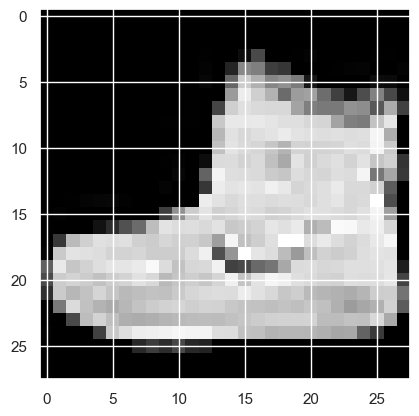

In [14]:
plt.imshow(torch_train_images[0].reshape(28, 28), cmap='gray') # show the first image
print(torch_train_labels[0]) # show the label of the first image

In [15]:
class CustomDataset(Dataset): # inherit from the base class
    def __init__(self, data_x, data_y): # define the constructor
        self.data_x = data_x # store the data
        self.data_y = data_y 

    def __len__(self): # define the length function
        length = len(self.data_x) # get the length of the data
        return length # return the length

    def __getitem__(self, index): # define the get item function
        # Get the x and y at a given position (index) in the data
        x = self.data_x[index] 
        y = self.data_y[index]
        return x, y

In [16]:
dataset_train = CustomDataset(data_x=torch_train_images, data_y=torch_train_labels) # create an instance of the dataset
dataloader_train = DataLoader(dataset=dataset_train, batch_size=60, num_workers=0) # create an instance of the data loader

dataset_test = CustomDataset(data_x=torch_test_images, data_y=torch_test_labels) # create an instance of the dataset
dataloader_test = DataLoader(dataset=dataset_test, batch_size=60, num_workers=0) # create an instance of the data loader

In [17]:
list_batch_images = []
list_batch_labels = []

for point in dataloader_train: # loop over the data
    batch_images, batch_labels = point # get the batch
    list_batch_images.append(batch_images) # store the batch
    list_batch_labels.append(batch_labels)

print(batch_images.shape, batch_labels.shape)

torch.Size([60, 1, 28, 28]) torch.Size([60])


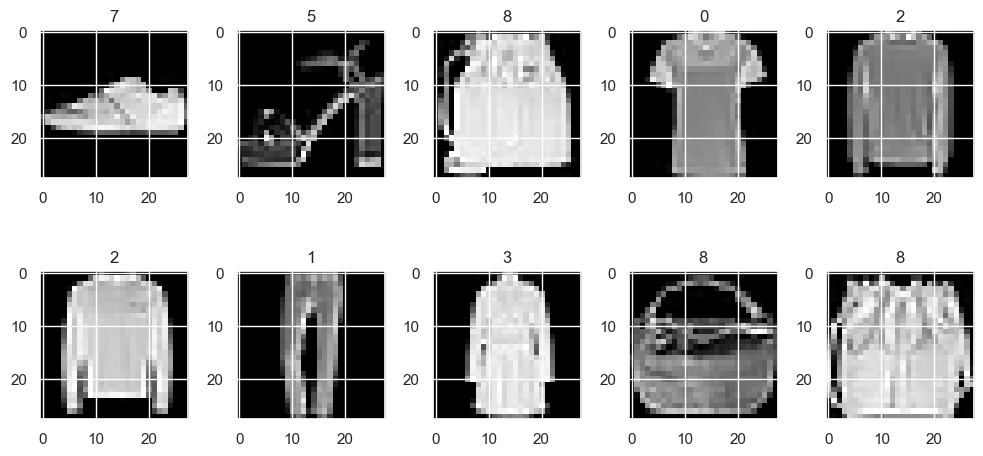

In [18]:
# plot all the images in the batch

fig, axes = plt.subplots(2, 5, figsize=(10, 5)) # create a figure
axes = axes.reshape(-1) # reshape the axes
for i in range(10): # loop over the axes
    axes[i].imshow(batch_images[i].reshape(28, 28), cmap='gray') # plot the image
    axes[i].set_title(batch_labels[i].item()) # set the title
plt.tight_layout() # adjust the layout
plt.show() # show the plot

In [19]:
# LeNet model
def create_lenet():
    model = torch.nn.Sequential(
        torch.nn.Conv2d(1, 6, 5, padding=2), # 1 input channel, 6 output channels, 5x5 kernel, padding 2
        torch.nn.ReLU(), # ReLU activation
        torch.nn.MaxPool2d(kernel_size=2), # max pooling with 2x2 kernel

        torch.nn.Conv2d(6, 16, 5, padding=0), # 6 input channels, 16 output channels, 5x5 kernel, padding 0
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2), 
        
        torch.nn.Flatten(), # flatten the output of the previous layer
        torch.nn.Linear(400, 120), # 400 input features, 120 output features
        torch.nn.ReLU(),
        torch.nn.Linear(120, 84), # 120 input features, 84 output features
        torch.nn.ReLU(),
        torch.nn.Linear(84, 10), # 84 input features, 10 output features (one for each class)
    )
    return model

In [20]:
# validate the model

def validate(model):
    total = 0
    correct = 0

    for i, (images, labels) in enumerate(dataloader_test): 
        images = images.to('mps') # move the images to the MPS # MPS is Metal Performance Shaders (MPS) for PyTorch
        x = model(images) # get the output labels of the model
        value, pred = torch.max(x,1) # get the predicted labels
        pred = pred.cpu() # move the predicted labels to the CPU
        total += x.size(0)
        correct += torch.sum(pred == labels) # count the number of correct predictions


    return correct*100/total

In [21]:
# train the model
def train(n_epochs,lr=1e-3,device='cpu'): 
    accuracies = []
    cnn = create_lenet().to(device) # create the model and move it to the device
    cec = nn.CrossEntropyLoss() # define the loss function
    optimizer = torch.optim.Adam(cnn.parameters(), lr=lr) # define the optimizer
    max_accuracy =0
    start = time.time() # start the timer

    for epoch in range(n_epochs):
        for i, (images, labels) in enumerate(dataloader_train):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad() # zero the gradients
            pred = cnn(images) # get the output labels of the model
            loss = cec(pred, labels) # calculate the loss
            loss.backward() # backpropagate the loss
            optimizer.step() # update the weights
            accuracy = float(validate(cnn)) # calculate the accuracy
            if (i+1) % 500 == 0:
                print("Epoch: ", epoch+1, "/", n_epochs,"| Step: ", i+1, "| Accuracy: ", accuracy, "%")
            accuracies.append(accuracy)
        if accuracy > max_accuracy: # save the best model
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving best model with accuracy: ", accuracy)
        print("Epoch: ", epoch+1, " Accuracy: ", accuracy, "%")
        print("Time taken for epoch: ", round((time.time() - start)/60,1), " minutes")
        # start = time.time()
    plt.plot(accuracies)
    return best_model

In [22]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu' # check if cuda is available
# device = torch.device('mps')

In [23]:
device

'mps'

In [24]:
torch_train_images.to(device) # move the data to the gpu or mps in mac
torch_train_labels.to(device)
torch_test_images.to(device)
torch_test_labels.to(device)

tensor([9, 2, 1,  ..., 8, 1, 5], device='mps:0', dtype=torch.uint8)

Epoch:  1 / 5 | Step:  100 | Accuracy:  70.72000122070312 %
Epoch:  1 / 5 | Step:  200 | Accuracy:  73.8499984741211 %
Epoch:  1 / 5 | Step:  300 | Accuracy:  77.05999755859375 %
Epoch:  1 / 5 | Step:  400 | Accuracy:  77.18000030517578 %
Epoch:  1 / 5 | Step:  500 | Accuracy:  76.08000183105469 %
Epoch:  1 / 5 | Step:  600 | Accuracy:  76.8499984741211 %
Epoch:  1 / 5 | Step:  700 | Accuracy:  71.97000122070312 %
Epoch:  1 / 5 | Step:  800 | Accuracy:  77.76000213623047 %
Epoch:  1 / 5 | Step:  900 | Accuracy:  79.41999816894531 %
Epoch:  1 / 5 | Step:  1000 | Accuracy:  78.08000183105469 %
Saving best model with accuracy:  78.08000183105469
Epoch:  1  Accuracy:  78.08000183105469 %
Epoch:  2 / 5 | Step:  100 | Accuracy:  78.56999969482422 %
Epoch:  2 / 5 | Step:  200 | Accuracy:  78.41000366210938 %
Epoch:  2 / 5 | Step:  300 | Accuracy:  78.63999938964844 %
Epoch:  2 / 5 | Step:  400 | Accuracy:  78.87000274658203 %
Epoch:  2 / 5 | Step:  500 | Accuracy:  79.30999755859375 %
Epoch: 

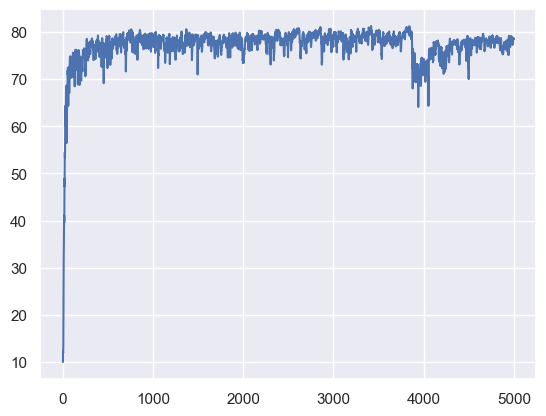

In [26]:
lenet = train(5, lr=0.02, device=device)

Epoch:  1 / 5 | Step:  100 | Accuracy:  79.27999877929688 %
Epoch:  1 / 5 | Step:  200 | Accuracy:  82.69999694824219 %
Epoch:  1 / 5 | Step:  300 | Accuracy:  81.54000091552734 %
Epoch:  1 / 5 | Step:  400 | Accuracy:  84.0199966430664 %
Epoch:  1 / 5 | Step:  500 | Accuracy:  84.5 %
Epoch:  1 / 5 | Step:  600 | Accuracy:  84.30999755859375 %
Epoch:  1 / 5 | Step:  700 | Accuracy:  85.51000213623047 %
Epoch:  1 / 5 | Step:  800 | Accuracy:  85.2300033569336 %
Epoch:  1 / 5 | Step:  900 | Accuracy:  86.30999755859375 %
Epoch:  1 / 5 | Step:  1000 | Accuracy:  85.25 %
Saving best model with accuracy:  85.25
Epoch:  1  Accuracy:  85.25 %
Epoch:  2 / 5 | Step:  100 | Accuracy:  86.16999816894531 %
Epoch:  2 / 5 | Step:  200 | Accuracy:  86.43000030517578 %
Epoch:  2 / 5 | Step:  300 | Accuracy:  85.56999969482422 %
Epoch:  2 / 5 | Step:  400 | Accuracy:  84.91999816894531 %
Epoch:  2 / 5 | Step:  500 | Accuracy:  86.0999984741211 %
Epoch:  2 / 5 | Step:  600 | Accuracy:  86.73999786376953

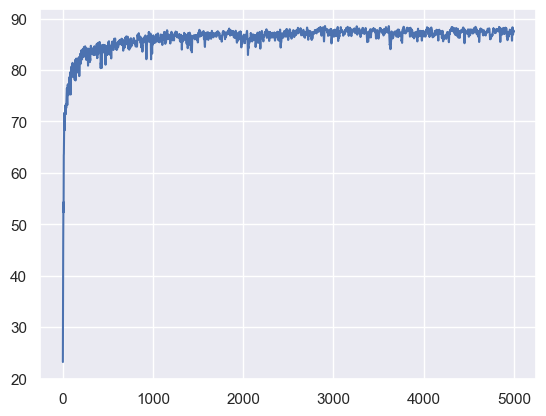

In [27]:
lenet = train(5, lr=0.003, device=device)

Epoch:  1 / 10 | Step:  500 | Accuracy:  83.55000305175781 %
Epoch:  1 / 10 | Step:  1000 | Accuracy:  84.1500015258789 %
Saving best model with accuracy:  84.1500015258789
Epoch:  1  Accuracy:  84.1500015258789 %
Time taken for epoch:  5.9  minutes
Epoch:  2 / 10 | Step:  500 | Accuracy:  85.08000183105469 %
Epoch:  2 / 10 | Step:  1000 | Accuracy:  85.4800033569336 %
Saving best model with accuracy:  85.4800033569336
Epoch:  2  Accuracy:  85.4800033569336 %
Time taken for epoch:  6.0  minutes
Epoch:  3 / 10 | Step:  500 | Accuracy:  86.0199966430664 %
Epoch:  3 / 10 | Step:  1000 | Accuracy:  86.08999633789062 %
Saving best model with accuracy:  86.08999633789062
Epoch:  3  Accuracy:  86.08999633789062 %
Time taken for epoch:  5.9  minutes
Epoch:  4 / 10 | Step:  500 | Accuracy:  86.55000305175781 %
Epoch:  4 / 10 | Step:  1000 | Accuracy:  87.12000274658203 %
Saving best model with accuracy:  87.12000274658203
Epoch:  4  Accuracy:  87.12000274658203 %
Time taken for epoch:  5.9  min

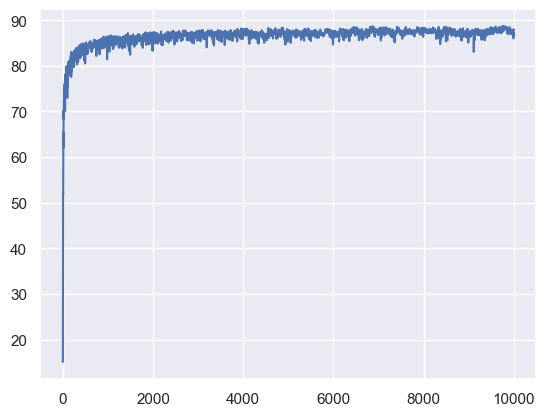

In [77]:
lenet = train(10, lr=0.003, device=device) # best model

In [31]:
# LeNet model
def create_lenet2():
    model = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, 3, padding=1), # 1 input channel, 32 output channels, 3x3 kernel, padding 1
        torch.nn.ReLU(), # ReLU activation
        torch.nn.MaxPool2d(kernel_size=2), # max pooling with 2x2 kernel

        torch.nn.Conv2d(32, 64, 3, padding=1), # 32 input channels, 64 output channels, 3x3 kernel, padding 1
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2), 
        
        torch.nn.Flatten(), # flatten the output of the previous layer
        torch.nn.Linear( 64 * 7 * 7, 128), # 3136 input features, 128 output features
        torch.nn.ReLU(),
        torch.nn.Linear(128, 10), # 128 input features, 10 output features (10 classes)
    )
    return model

In [30]:
# train the model
def train2(n_epochs,lr=1e-3,device='cpu'): 
    accuracies = []
    cnn = create_lenet2().to(device) # create the model and move it to the device
    cec = nn.CrossEntropyLoss() # define the loss function
    optimizer = torch.optim.Adam(cnn.parameters(), lr=lr) # define the optimizer
    max_accuracy =0
    start = time.time() # start the timer

    for epoch in range(n_epochs):
        for i, (images, labels) in enumerate(dataloader_train):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad() # zero the gradients
            pred = cnn(images) # get the output labels of the model
            loss = cec(pred, labels) # calculate the loss
            loss.backward() # backpropagate the loss
            optimizer.step() # update the weights
            accuracy = float(validate(cnn)) # calculate the accuracy
            if (i+1) % 500 == 0:
                print("Epoch: ", epoch+1, "/", n_epochs,"| Step: ", i+1, "| Accuracy: ", accuracy, "%")
            accuracies.append(accuracy)
        if accuracy > max_accuracy: # save the best model
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving best model with accuracy: ", accuracy)
        print("Epoch: ", epoch+1, " Accuracy: ", accuracy, "%")
        print("Time taken for epoch: ", round((time.time() - start)/60,1), " minutes")
        start = time.time()
    plt.plot(accuracies)
    return best_model

Epoch:  1 / 5 | Step:  500 | Accuracy:  82.4000015258789 %
Epoch:  1 / 5 | Step:  1000 | Accuracy:  82.20999908447266 %
Saving best model with accuracy:  82.20999908447266
Epoch:  1  Accuracy:  82.20999908447266 %
Time taken for epoch:  8.1  minutes
Epoch:  2 / 5 | Step:  500 | Accuracy:  85.83000183105469 %
Epoch:  2 / 5 | Step:  1000 | Accuracy:  84.4800033569336 %
Saving best model with accuracy:  84.4800033569336
Epoch:  2  Accuracy:  84.4800033569336 %
Time taken for epoch:  22.1  minutes
Epoch:  3 / 5 | Step:  500 | Accuracy:  86.31999969482422 %
Epoch:  3 / 5 | Step:  1000 | Accuracy:  85.20999908447266 %
Saving best model with accuracy:  85.20999908447266
Epoch:  3  Accuracy:  85.20999908447266 %
Time taken for epoch:  35.5  minutes
Epoch:  4 / 5 | Step:  500 | Accuracy:  86.83000183105469 %
Epoch:  4 / 5 | Step:  1000 | Accuracy:  86.4800033569336 %
Saving best model with accuracy:  86.4800033569336
Epoch:  4  Accuracy:  86.4800033569336 %
Time taken for epoch:  48.5  minutes


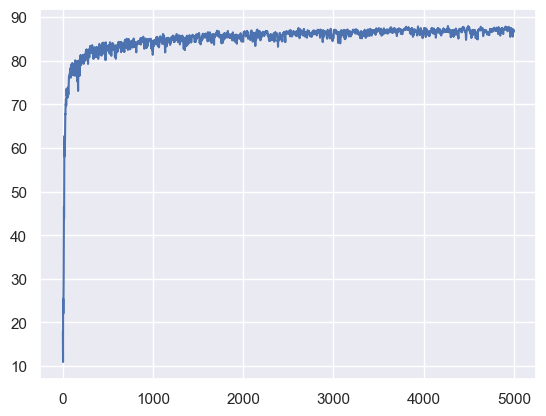

In [32]:
lenet2 = train2(5, lr=0.003, device=device)

#### other models that can be used

1. AlexNet # AlexNet is a convolutional neural network that is 8 layers deep.
2. VGG # VGG is a convolutional neural network that is 19 layers deep.
3. ResNet # ResNet is a convolutional neural network that is 152 layers deep.
4. SqueezeNet # SqueezeNet is a convolutional neural network that is 50 layers deep.